# Getting Started with pyGAM

## Introduction

Generalized Additive Models (GAMs) are smooth semi-parametric models of the form:

$$
    g(\mathbb{E}[y|X]) = \beta_0 + f_1(X_1) + f_2(X_2) + \ldots + f_p(X_p)
$$

where `X.T = [X_1, X_2, ..., X_p]` are independent variables, `y` is the dependent variable, and `g()` is the link function that relates our predictor variables to the expected value of the dependent variable.

The feature functions `f_i()` are built using **penalized B splines**, which allow us to **automatically model non-linear relationships** without having to manually try out many different transformations on each variable.


![Basis splines](pygam_basis.png)

GAMs extend generalized linear models by allowing non-linear functions of features while maintaining additivity. Since the model is additive, it is easy to examine the effect of each `X_i` on `Y` individually while holding all other predictors constant.

The result is a very flexible model, where it is easy to incorporate prior knowledge and control overfitting.



## Regression

For **regression** problems, we can use a **linear GAM** which models:

$$
    \mathbb{E}[y|X]=\beta_0+f_1(X_1)+f_2(X_2)+\dots+f_p(X_p)
$$

In [1]:
import matplotlib.pyplot as plt

In [2]:
plt.ion()
plt.rcParams['figure.figsize'] = (12, 8)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


<Figure size 864x576 with 0 Axes>

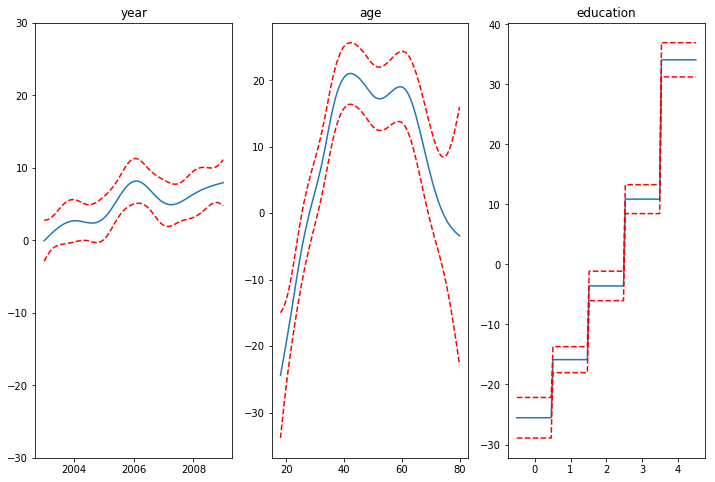

In [3]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage

X, y = wage(return_X_y=True)

gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)

plt.figure();
fig, axs = plt.subplots(1,3);

titles = ['year', 'age', 'education']
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX));
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--');
    if i == 0:
        ax.set_ylim(-30,30);
    ax.set_title(titles[i]);

Even though our model allows coefficients, our smoothing penalty reduces us to just 19 effective degrees of freedom:

In [4]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.2602
Link Function:                     IdentityLink Log Likelihood:                                -24116.7451
Number of Samples:                         3000 AIC:                                            48274.0107
                                                AICc:                                           48274.2999
                                                GCV:                                             1250.3656
                                                Scale:                                           1235.9245
                                                Pseudo R-Squared:                                   0.2945
Feature Function                  Lam

With **LinearGAMs**, we can also check the **prediction intervals**:

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


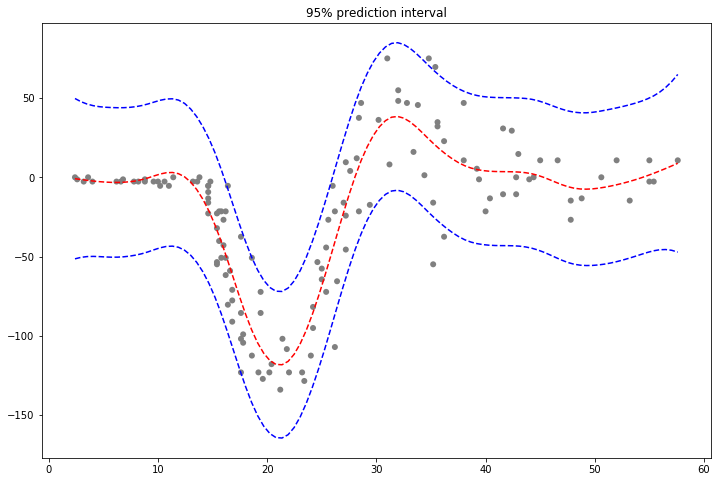

In [5]:
from pygam import LinearGAM
from pygam.datasets import mcycle

X, y = mcycle(return_X_y=True)

gam = LinearGAM().gridsearch(X, y)
XX = gam.generate_X_grid(term=0)

plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

plt.scatter(X, y, facecolor='gray', edgecolors='none')
plt.title('95% prediction interval');


And simulate from the posterior:

Text(0.5,1,'draw samples from the posterior of the coefficients')

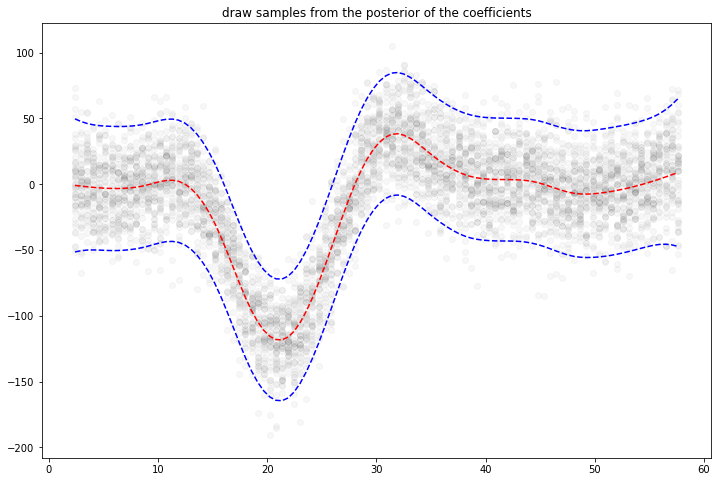

In [6]:
# continuing last example with the mcycle dataset
for response in gam.sample(X, y, quantity='y', n_draws=50, sample_at_X=XX):
    plt.scatter(XX, response, alpha=.03, color='k')
plt.plot(XX, gam.predict(XX), 'r--')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')
plt.title('draw samples from the posterior of the coefficients')


## Classification

For **binary classification** problems, we can use a **logistic GAM** which models:

$$
    log\left(\frac{P(y=1|X)}{P(y=0|X)}\right)=\beta_0+f_1(X_1)+f_2(X_2)+\dots+f_p(X_p)
$$

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


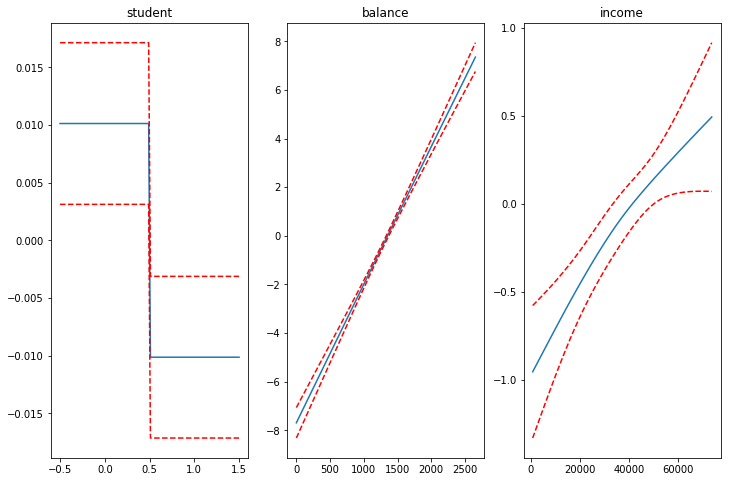

In [7]:
from pygam import LogisticGAM, s, f
from pygam.datasets import default

X, y = default(return_X_y=True)

gam = LogisticGAM(f(0) + s(1) + s(2)).gridsearch(X, y)

fig, axs = plt.subplots(1, 3)
titles = ['student', 'balance', 'income']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);


We can then check the accuracy:

In [8]:
gam.accuracy(X, y)

0.9739

Since the **scale** of the **Binomial distribution** is known, our gridsearch minimizes the **Un-Biased Risk Estimator** (UBRE) objective:

In [9]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.8047
Link Function:                        LogitLink Log Likelihood:                                   -788.877
Number of Samples:                        10000 AIC:                                             1585.3634
                                                AICc:                                             1585.369
                                                UBRE:                                               2.1588
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4598
Feature Function                  Lam

## Poisson and Histogram Smoothing
We can intuitively perform **histogram smoothing** by modeling the counts in each bin
as being distributed Poisson via **PoissonGAM**.

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


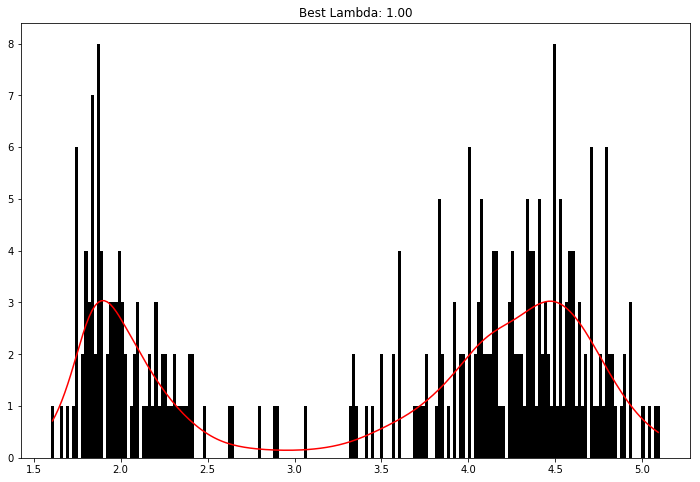

In [10]:
from pygam import PoissonGAM
from pygam.datasets import faithful

X, y = faithful(return_X_y=True)

gam = PoissonGAM().gridsearch(X, y)

plt.hist(faithful(return_X_y=False)['eruptions'], bins=200, color='k');
plt.plot(X, gam.predict(X), color='r')
plt.title('Best Lambda: {0:.2f}'.format(gam.lam[0][0]));

## Terms and Interactions

pyGAM can also fit interactions using tensor products via `te()`

In [17]:
from pygam import LinearGAM, s, te
from pygam.datasets import chicago

X, y = chicago(return_X_y=True)

gam = PoissonGAM(s(0, n_splines=200) + te(3, 1) + s(2)).fit(X, y)

and plot a 3D surface:

In [19]:
XX

(array([-2556.5       , -2504.85353535, -2453.20707071, -2401.56060606,
        -2349.91414141, -2298.26767677, -2246.62121212, -2194.97474747,
        -2143.32828283, -2091.68181818, -2040.03535354, -1988.38888889,
        -1936.74242424, -1885.0959596 , -1833.44949495, -1781.8030303 ,
        -1730.15656566, -1678.51010101, -1626.86363636, -1575.21717172,
        -1523.57070707, -1471.92424242, -1420.27777778, -1368.63131313,
        -1316.98484848, -1265.33838384, -1213.69191919, -1162.04545455,
        -1110.3989899 , -1058.75252525, -1007.10606061,  -955.45959596,
         -903.81313131,  -852.16666667,  -800.52020202,  -748.87373737,
         -697.22727273,  -645.58080808,  -593.93434343,  -542.28787879,
         -490.64141414,  -438.99494949,  -387.34848485,  -335.7020202 ,
         -284.05555556,  -232.40909091,  -180.76262626,  -129.11616162,
          -77.46969697,   -25.82323232,    25.82323232,    77.46969697,
          129.11616162,   180.76262626,   232.40909091,   284.05

In [ ]:
XX = gam.generate_X_grid(term=1, meshgrid=True)
Z = gam.partial_dependence(term=0, X=XX, meshgrid=True)

from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.plot_surface(XX[0], XX[1], Z, cmap='viridis')

For simple interactions it is sometimes useful to add a by-variable to a term

In [ ]:
from pygam import LinearGAM, s
from pygam.datasets import toy_interaction

X, y = toy_interaction(return_X_y=True)

gam = LinearGAM(s(0, by=1)).fit(X, y)
gam.summary()

#### Available Terms
- `l()` linear terms
- `s()` spline terms
- `f()` factor terms
- `te()` tensor products
- `intercept`

## Custom Models

It's also easy to build custom models, by using the base **GAM** class and specifying the **distribution** and the **link function**.`

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Text(0,0.5,'predicted volume')

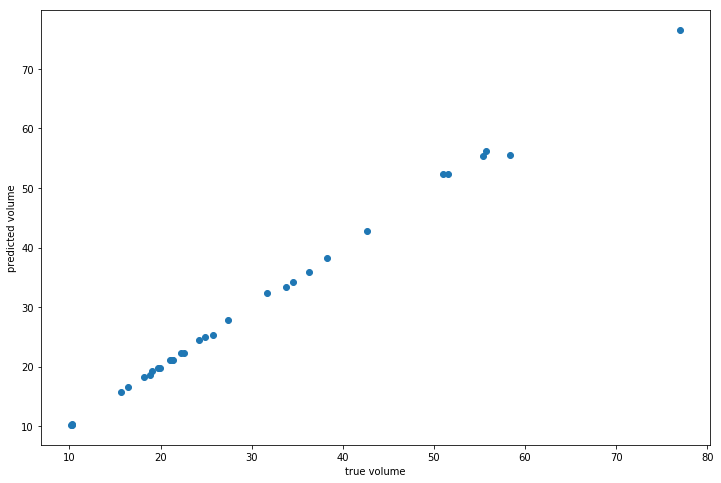

In [11]:
from pygam import GAM
from pygam.datasets import trees

X, y = trees(return_X_y=True)

gam = GAM(distribution='gamma', link='log')
gam.gridsearch(X, y)

plt.scatter(y, gam.predict(X))
plt.xlabel('true volume')
plt.ylabel('predicted volume')


We can check the quality of the fit by looking at the Pseudo R-Squared:

In [12]:
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     25.3616
Link Function:                          LogLink Log Likelihood:                                   -26.1673
Number of Samples:                           31 AIC:                                              105.0579
                                                AICc:                                             501.5549
                                                GCV:                                                0.0088
                                                Scale:                                               0.001
                                                Pseudo R-Squared:                                   0.9993
Feature Function                  Lam

## Penalties / Constraints

With GAMs we can encode **prior knowledge** and **control overfitting** by using penalties and constraints.

**Available penalties**
- second derivative smoothing (default on numerical features)
- L2 smoothing (default on categorical features)

**Availabe constraints**
- monotonic increasing/decreasing smoothing
- convex/concave smoothing
- periodic smoothing [soon...]


We can inject our intuition into our model by using **monotonic** and **concave** constraints:


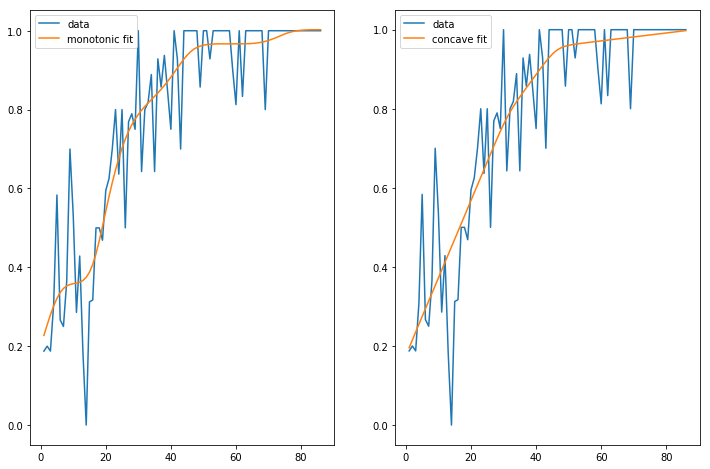

In [13]:
from pygam import LinearGAM, s
from pygam.datasets import hepatitis

X, y = hepatitis(return_X_y=True)

gam1 = LinearGAM(s(0, constraints='monotonic_inc')).fit(X, y)
gam2 = LinearGAM(s(0, constraints='concave')).fit(X, y)

fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, label='data')
ax[0].plot(X, gam1.predict(X), label='monotonic fit')
ax[0].legend()

ax[1].plot(X, y, label='data')
ax[1].plot(X, gam2.predict(X), label='concave fit')
ax[1].legend()

## API

pyGAM is intuitive, modular, and adheres to a familiar API:

In [14]:
from pygam import LogisticGAM, s, f
from pygam.datasets import toy_classification

X, y = toy_classification(return_X_y=True, n=5000)

gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + f(5))
gam.fit(X, y)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, lam=[0.6, 0.6, 0.6, 0.6, 0.6, 0.6], 
   max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + f(5) + intercept, 
   tol=0.0001, verbose=False)

Since GAMs are additive, it is also super easy to visualize each individual **feature function**, `f_i(X_i)`. These feature functions describe the effect of each `X_i` on `y` individually while marginalizing out all other predictors:


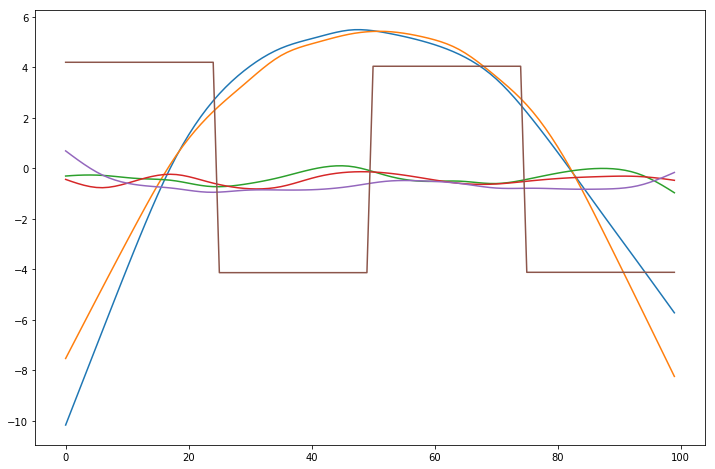

In [15]:
plt.figure()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))


## Current Features

### Models
pyGAM comes with many models out-of-the-box:

- GAM (base class for constructing custom models)
- LinearGAM
- LogisticGAM
- GammaGAM
- PoissonGAM
- InvGaussGAM
- ExpectileGAM

### Distributions

- Normal
- Binomial
- Gamma
- Poisson
- Inverse Gaussian

### Link Functions
Link functions take the distribution mean to the linear prediction. These are the canonical link functions for the above distributions:

- Identity
- Logit
- Inverse
- Log
- Inverse-squared

### Callbacks
Callbacks are performed during each optimization iteration. It's also easy to write your own.

- deviance - model deviance
- diffs - differences of coefficient norm
- accuracy - model accuracy for LogisticGAM
- coef - coefficient logging

You can check a callback by inspecting:


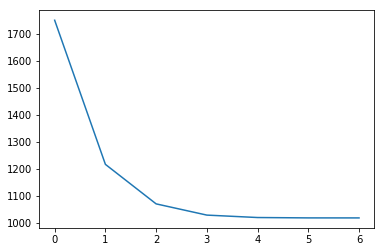

In [7]:
_ = plt.plot(gam.logs_['deviance'])

### Linear Extrapolation

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


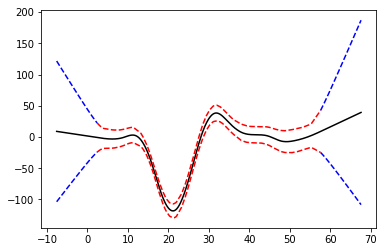

In [9]:
from pygam import LinearGAM
from pygam.datasets import mcycle

X, y = mcycle()

gam = LinearGAM()
gam.gridsearch(X, y)

XX = gam.generate_X_grid(term=0)

m = X.min()
M = X.max()
XX = np.linspace(m - 10, M + 10, 500)
Xl = np.linspace(m - 10, m, 50)
Xr = np.linspace(M, M + 10, 50)

plt.figure()

plt.plot(XX, gam.predict(XX), 'k')
plt.plot(Xl, gam.confidence_intervals(Xl), color='b', ls='--')
plt.plot(Xr, gam.confidence_intervals(Xr), color='b', ls='--')
_ = plt.plot(X, gam.confidence_intervals(X), color='r', ls='--')

## Citing pyGAM
Please consider citing pyGAM if it has helped you in your research or work:

Daniel Servén, & Charlie Brummitt. (2018, March 27). pyGAM: Generalized Additive Models in Python. Zenodo. [DOI: 10.5281/zenodo.1208723](http://doi.org/10.5281/zenodo.1208723)

BibTex:

    @misc{daniel\_serven\_2018_1208723,
      author       = {Daniel Servén and
                      Charlie Brummitt},
      title        = {pyGAM: Generalized Additive Models in Python},
      month        = mar,
      year         = 2018,
      doi          = {10.5281/zenodo.1208723},
      url          = {https://doi.org/10.5281/zenodo.1208723}
    }

## References
1. Simon N. Wood, 2006  
Generalized Additive Models: an introduction with R

0. Hastie, Tibshirani, Friedman  
The Elements of Statistical Learning  
http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf  

0. James, Witten, Hastie and Tibshirani  
An Introduction to Statistical Learning  
http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf  

0. Paul Eilers & Brian Marx, 1996
Flexible Smoothing with B-splines and Penalties
http://www.stat.washington.edu/courses/stat527/s13/readings/EilersMarx_StatSci_1996.pdf

0. Kim Larsen, 2015  
GAM: The Predictive Modeling Silver Bullet  
http://multithreaded.stitchfix.com/assets/files/gam.pdf  

0. Deva Ramanan, 2008  
UCI Machine Learning: Notes on IRLS  
http://www.ics.uci.edu/~dramanan/teaching/ics273a_winter08/homework/irls_notes.pdf  

0. Paul Eilers & Brian Marx, 2015  
International Biometric Society: A Crash Course on P-splines  
http://www.ibschannel2015.nl/project/userfiles/Crash_course_handout.pdf

0. Keiding, Niels, 1991  
Age-specific incidence and prevalence: a statistical perspective
